# Case Study: Stock Trend Prediction using Simple RNN
### Overview
Predict the next-day stock *trend* (Up / Down) using the previous 10 days of closing prices.

This notebook is structured to look like a human-created teaching notebook with clear sections:
1. Problem description and motivation
2. Data generation (realistic synthetic data)
3. Exploratory plots
4. Preprocessing and feature engineering
5. Model architecture and code
6. Training and hyperparameters
7. Evaluation (metrics and confusion matrix)
8. Prediction on unseen samples
9. Save and load model demo

Let's begin!


## 1) Problem description
We want a binary classifier that takes the previous 10 days' closing prices and predicts whether the price will go UP (1) or DOWN (0) the next day. This demonstrates how a Simple RNN uses recent time steps and why it may struggle with long-range dependencies.

## 2) Generate synthetic stock-like data
We'll create a time series with trend, seasonality, and noise so the dataset resembles a real stock's closing price. This lets us run everything offline.

In [16]:
# Data generation and simple EDA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [17]:
np.random.seed(42)
days = 1200
t = np.arange(days)

In [18]:
# realistic-ish signal: baseline + slow trend + weekly seasonality + noise
prices = 50 + 0.02 * t + 3 * np.sin(2 * np.pi * t / 60) + np.random.normal(scale=0.8, size=days)
prices = prices.astype('float32')

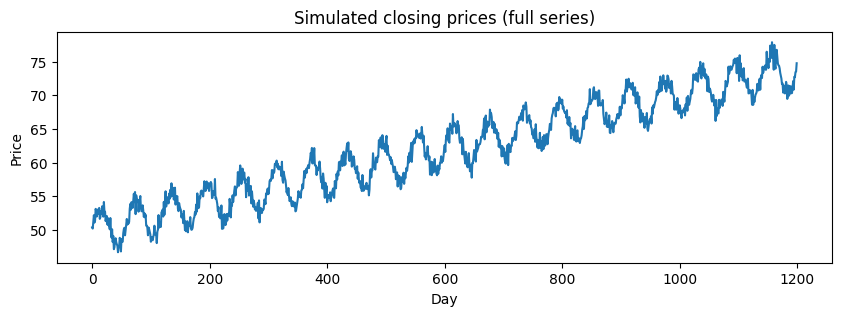

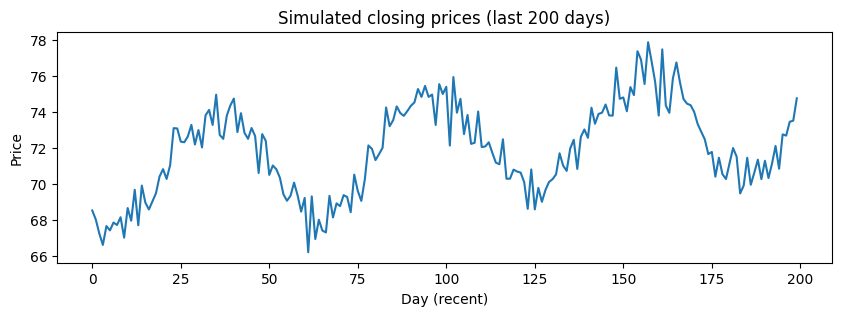

In [19]:
# Plot the full series and a zoomed window
plt.figure(figsize=(10,3))
plt.plot(prices)
plt.title('Simulated closing prices (full series)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(prices[-200:])
plt.title('Simulated closing prices (last 200 days)')
plt.xlabel('Day (recent)')
plt.ylabel('Price')
plt.show()

In [20]:
# Prepare sequences: last 10 days -> next day trend (1 if next day's price > last day in window)
window = 10
X = []
y = []
for i in range(len(prices) - window - 1):
    seq = prices[i:i+window]
    next_price = prices[i+window]
    trend = 1 if next_price > seq[-1] else 0
    X.append(seq)
    y.append(trend)

In [21]:
import numpy as np
X = np.array(X)
y = np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)
print("Class balance (UP=1):", y.mean())

X shape: (1189, 10) y shape: (1189,)
Class balance (UP=1): 0.511354079058032


In [22]:
# Scale features per-sample (min-max) to keep example simple and stable
scaler = MinMaxScaler()
X_flat = X.reshape(-1,1)
X_scaled = scaler.fit_transform(X_flat).reshape(X.shape)

In [23]:
# reshape for RNN: (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [24]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

In [25]:
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

Train samples: 951 Test samples: 238


## 3) Model workflow & architecture
We'll use a **SimpleRNN** layer with a Dense output (sigmoid). The workflow is:

Data (10-day windows) -> MinMax scaling -> SimpleRNN -> Dense(sigmoid) -> Binary prediction

Below is a small diagram drawn with matplotlib to visualize the flow.

## 4) Build, train and evaluate the SimpleRNN model
We include clear comments on why we choose certain hyperparameters (units, lr, epochs).

In [26]:
# Build, train, evaluate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
model = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(window,1)),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting & save training time
early_stop = EarlyStopping(
    monitor='val_loss',     # monitor validation loss
    patience=10,            # stop if no improvement for 10 epochs
    restore_best_weights=True,  # revert to best model
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=1000,           # large number, but early stopping will kick in
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)


Epoch 1/1000
27/27 - 0s - 13ms/step - accuracy: 0.7813 - loss: 0.4448 - val_accuracy: 0.6979 - val_loss: 0.6558
Epoch 2/1000
27/27 - 1s - 20ms/step - accuracy: 0.7871 - loss: 0.4430 - val_accuracy: 0.6875 - val_loss: 0.6622
Epoch 3/1000
27/27 - 0s - 13ms/step - accuracy: 0.7836 - loss: 0.4474 - val_accuracy: 0.6875 - val_loss: 0.6507
Epoch 4/1000
27/27 - 0s - 8ms/step - accuracy: 0.7848 - loss: 0.4445 - val_accuracy: 0.6562 - val_loss: 0.7062
Epoch 5/1000
27/27 - 0s - 9ms/step - accuracy: 0.7731 - loss: 0.4544 - val_accuracy: 0.6771 - val_loss: 0.6606
Epoch 6/1000
27/27 - 0s - 6ms/step - accuracy: 0.7789 - loss: 0.4465 - val_accuracy: 0.6875 - val_loss: 0.6614
Epoch 7/1000
27/27 - 0s - 12ms/step - accuracy: 0.7848 - loss: 0.4445 - val_accuracy: 0.7083 - val_loss: 0.6983
Epoch 8/1000
27/27 - 0s - 11ms/step - accuracy: 0.7871 - loss: 0.4427 - val_accuracy: 0.6771 - val_loss: 0.7206
Epoch 9/1000
27/27 - 0s - 11ms/step - accuracy: 0.7860 - loss: 0.4431 - val_accuracy: 0.6875 - val_loss: 0.

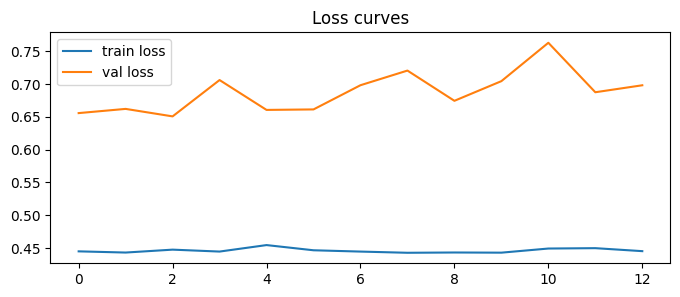

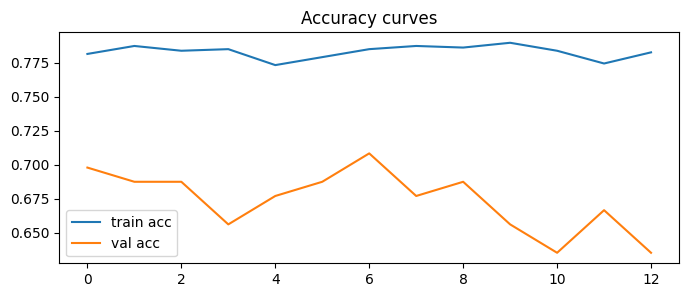

In [31]:
# Plot training curves
plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss curves')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy curves')
plt.legend()
plt.show()

In [32]:
# Evaluate on test set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test accuracy: 0.6302521008403361

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62       112
           1       0.66      0.63      0.64       126

    accuracy                           0.63       238
   macro avg       0.63      0.63      0.63       238
weighted avg       0.63      0.63      0.63       238



In [33]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\\n", cm)


Confusion matrix:\n [[71 41]
 [47 79]]


## 5) Predict on new/unseen windows
We demonstrate a few example predictions (take recent windows from the original series).

In [34]:
# Take last windows from original prices for demonstration
recent_windows = X_scaled[-6:]
probs = model.predict(recent_windows).ravel()
preds = (probs > 0.5).astype(int)
for i, (p,pr) in enumerate(zip(preds, probs)):
    print(f"Sample {i}: Predicted UP={p}, Prob={pr:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sample 0: Predicted UP=0, Prob=0.411
Sample 1: Predicted UP=0, Prob=0.178
Sample 2: Predicted UP=1, Prob=0.835
Sample 3: Predicted UP=0, Prob=0.111
Sample 4: Predicted UP=0, Prob=0.330
Sample 5: Predicted UP=0, Prob=0.289


## 6) Save and load the model (demo)
This shows how to persist the trained model and load it for inference in production or a demo.

In [35]:

# Save model
model_path = "rnn_stock_model.h5"
model.save(model_path)
print("Saved model to", model_path)

# Load to verify
from tensorflow.keras.models import load_model
m2 = load_model(model_path)
print("Loaded model, running a quick predict check:")
print(m2.predict(recent_windows[:2]))


Saved model to rnn_stock_model.h5
Loaded model, running a quick predict check:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
[[0.41082257]
 [0.17766297]]
